# Reproducing JPM’s US Rates Strategy RV Trade Idea 
## Note - `Treasuries: Whiplash` (14 June 2024)
## `100:98 weighted 4.75% Feb 37s / 4.5% Aug 39s steepeners`

```
Turning to relative value, we see opportunities in the 2036-38 sector, as these securities have underperformed significantly relative to our par curve over the last 4 weeks. In particular, we like to fade the cheapening in 4.75% Feb-37s (Figure 6). Separately, we note that 4.5% Aug-39s, the CTD into USM4, have outperformed recently, but this security will drop out of the US deliverable basket next week, and likely has room to cheapen. Further, as Figure 7 shows, the Feb-37/ Aug-39 appear 6.9bp too flat relative to the shape of 10s/20s. Against this backdrop, we recommend 100:98 weighted 4.75% Feb 37s / 4.5% Aug 39s steepeners (see Trade recommendations).
```

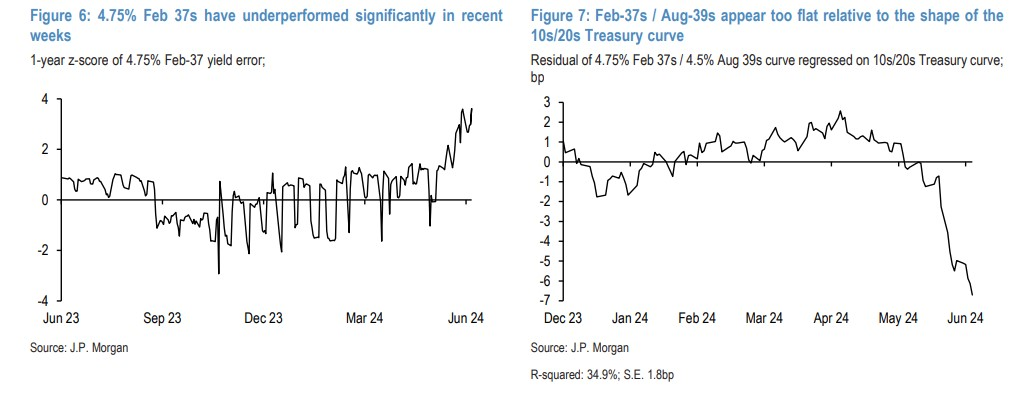

In [38]:
import sys
sys.path.append("../../")

In [39]:
from CurveInterpolator import GeneralCurveInterpolator
from CurveDataFetcher import CurveDataFetcher
from utils.rv_utils import cusip_spread_rv_regression
from utils.viz import plot_usts
from models.calibrate import calibrate_mles_ols, calibrate_nss_ols
from models.NelsonSiegelSvensson import NelsonSiegelSvenssonCurve

In [40]:
import pandas as pd
import numpy as np
import scipy
from datetime import datetime
from typing import Dict, List
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "axes.titlesize": "x-large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

import seaborn as sns
sns.set(style="whitegrid", palette="dark")

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import plotly
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True)

In [42]:
quote_type = "eod"
as_of_date = datetime(2024, 6, 14)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
    use_github=True,
)

curve_set_df

cusip security_type auction_date issue_date maturity_date  \
0    912797KF3          Bill   2024-05-16 2024-05-21    2024-06-18   
1    912797KG1          Bill   2024-05-23 2024-05-28    2024-06-25   
2    912797KH9          Bill   2024-05-30 2024-06-04    2024-07-02   
3    912797KN6          Bill   2024-06-06 2024-06-11    2024-07-09   
4    912797KP1          Bill   2024-05-16 2024-05-21    2024-07-16   
..         ...           ...          ...        ...           ...   
387  912810TR9          Bond   2023-07-13 2023-07-17    2053-05-15   
388  912810TT5          Bond   2023-10-12 2023-10-16    2053-08-15   
389  912810TV0          Bond   2024-01-11 2024-01-16    2053-11-15   
390  912810TX6          Bond   2024-04-11 2024-04-15    2054-02-15   
391  912810UA4          Bond   2024-05-09 2024-05-15    2054-05-15   

     time_to_maturity  int_rate  high_investment_rate is_on_the_run  \
0            0.010959       NaN                 5.365         False   
1            0.030137       NaN                 5.365         False   
2            0.049315       NaN                 5.365         False   
3            0.068493       NaN                 5.365          True   
4            0.087671       NaN                 5.387         False   
..                ...       ...                   ...           ...   
387         28.936986     3.625                   NaN         False   
388         29.189041     4.125                   NaN         False   
389         29.441096     4.750                   NaN         False   
390         29.693151     4.250                   NaN         False   
391         29.936986     4.625                   NaN          True   

         ust_label  ...      parValue percentOutstanding  est_outstanding_amt  \
0    5.365% Jun-24  ...  8.357725e+08           0.003873         2.157845e+11   
1    5.365% Jun-24  ...  8.312242e+08           0.003852         2.158075e+11   
2    5.365% Jul-24  ...  5.800708e+08           0.002822         2.055647e+11   
3    5.365% Jul-24  ...  5.812060e+08           0.002760         2.105957e+11   
4    5.387% Jul-24  ...  3.064740e+08           0.002184         1.403087e+11   
..             ...  ...           ...                ...                  ...   
387  3.625% May-53  ...  5.723292e+09           0.091437         6.259307e+10   
388  4.125% Aug-53  ...  8.606596e+09           0.120247         7.157430e+10   
389  4.750% Nov-53  ...  4.567153e+08           0.006874         6.644364e+10   
390  4.250% Feb-54  ...  2.211754e+09           0.031064         7.119879e+10   
391  4.625% May-54  ...  3.142249e+09           0.111657         2.814189e+10   

     corpus_cusip outstanding_amt  portion_unstripped_amt  \
0             NaN    0.000000e+00                     NaN   
1             NaN    0.000000e+00                     NaN   
2             NaN    0.000000e+00                     NaN   
3             NaN    0.000000e+00                     NaN   
4             NaN    0.000000e+00                     NaN   
..            ...             ...                     ...   
387     912803GS6    6.271107e+10              42364550.8   
388     912803GU1    7.158330e+10              62241373.0   
389     912803GW7    6.644364e+10              57664315.9   
390     912803GY3    7.119879e+10              61771996.7   
391     912803HB2    2.814189e+10              27729908.5   

     portion_stripped_amt  reconstituted_amt  free_float  rank  
0            0.000000e+00                NaN   -835.7725  16.0  
1            0.000000e+00                NaN   -831.2242  15.0  
2            0.000000e+00                NaN   -580.0708  14.0  
3            0.000000e+00                NaN   -581.2060  13.0  
4            0.000000e+00                NaN   -306.4740  12.0  
..                    ...                ...         ...   ...  
387          2.034652e+10          2692420.0  36641.2589   4.0  
388          9.341928e+09           154800.0  53634.7768   3.0  
389          8.779329e+0

## Build Par Curve Model

In [43]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):

    # remove OTRs, olds, double olds, triple olds
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"],  # TU
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"],  # Z3N
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"],  # FV
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"],  # TY
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"],  # TN
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"],  # US
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"],  # TWE
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"],  # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

    return curve_set_filtered_df


def no_filter(curve_set_df: pd.DataFrame):
    return curve_set_df

In [44]:
# filter and fit bspline w/ knots are liquidity points
curve_set_filtered_df = liquidity_premium_curve_set_filter(curve_set_df=curve_set_df)

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)

fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25],
    k=3,
    return_func=True,
)

nss_func, status_nss, _ = calibrate_nss_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_nss

mles_func, status_mles = calibrate_mles_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
    overnight_rate=5.31,
    N=9,
)

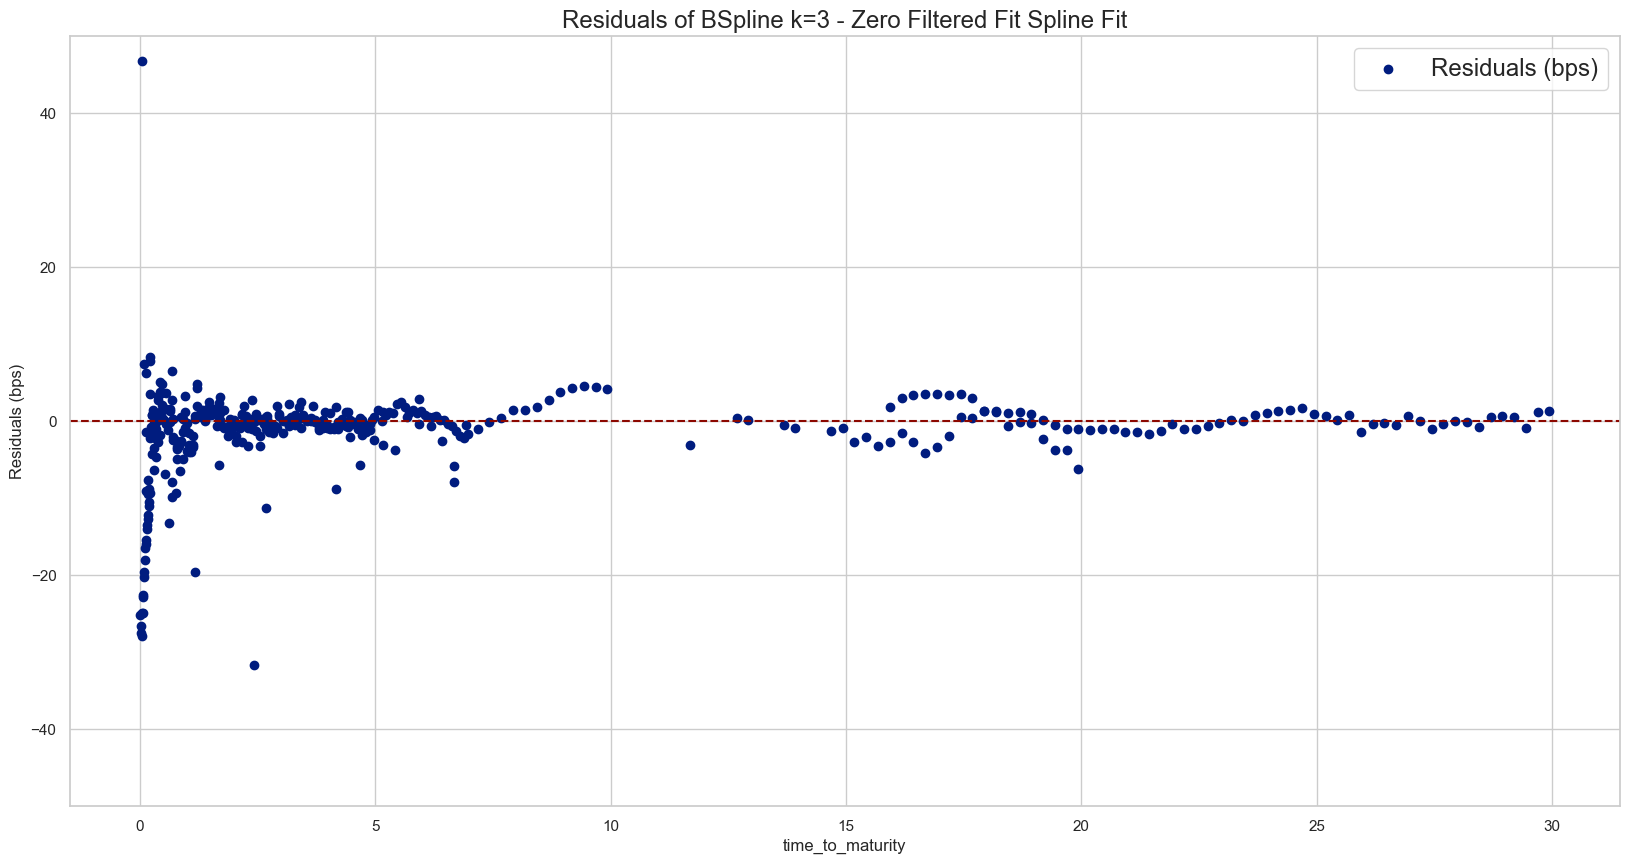

In [45]:
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"{quote_type}_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"{quote_type}_price",
        "free_float",
    ],
    ust_labels_highlighter=[
        ("4.750% Feb-37", "red"), ("4.500% Aug-39", "blue"), 
    ],
    zero_curves=[(fitted_bspline, "BSpline k=3 - Zero Filtered Fit"), (nss_func, "Nelson Siegel Svensson"), (mles_func, "Merrill Lynch Exponential Spline")],
    title=f"All USTs - using {f"{quote_type}_yield"} - as of {as_of_date}",
    y_axis_range=[3.9, 5.7]
)

## Fetching historical curve sets to regress  Feb-37s / Aug-39s vs our fitted model over time (10s/20s par curve)

In [46]:
start_date = datetime(2023, 12, 1)
end_date = datetime(2024, 6, 14)

curve_sets_dict_df, fitted_curves_dict = curve_data_fetcher.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[
        ("LPF", f"{quote_type}_yield", liquidity_premium_curve_set_filter),
        ("NSS", f"{quote_type}_yield", no_filter, calibrate_nss_ols),
    ],
)

AGGREGATING CURVE SET DFs: 100%|██████████| 174/174 [00:08<00:00, 20.98it/s]


In [47]:
cusip_timeseries: Dict[str, List[Dict[str, str | float | int]]] = {}
fitted_cubic_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_bspline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_smooth_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
nss_timeseries: Dict[datetime, NelsonSiegelSvenssonCurve] = {}

for dt in tqdm.tqdm(curve_sets_dict_df.keys(), desc="Main Loop"):
    fitted_cubic_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25],
        k=3,
        return_func=True,
    )
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25], k=5, return_func=True
    )
    fitted_smooth_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
    )
    curr_nss_model = fitted_curves_dict[dt]["NSS"]

    fitted_cubic_spline_timeseries[dt] = fitted_cubic_spline
    fitted_bspline_timeseries[dt] = fitted_bspline
    fitted_smooth_spline_timeseries[dt] = fitted_smooth_spline 
    nss_timeseries[dt] = curr_nss_model

    curr_curve_set_df = curve_sets_dict_df[dt]
    curr_curve_set_df["lpf_cubic_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_cubic_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_bspline_spread"] = curr_curve_set_df["eod_yield"] - fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_smooth_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_smooth_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["nf_nss_spread"] = curr_curve_set_df.apply(
        lambda row: row["eod_yield"] - curr_nss_model(row["time_to_maturity"])
        if pd.notna(row["eod_yield"]) and curr_nss_model(row["time_to_maturity"]) is not None
        else np.nan, axis=1
    )

    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_timeseries:
            cusip_timeseries[row["cusip"]] = []

        payload = {
            "Date": dt,
            "cusip": row["cusip"],
            f"{quote_type}_yield": row[f"{quote_type}_yield"],
            f"{quote_type}_price": row[f"{quote_type}_price"],
            "lpf_cubic_spline_spread": row["lpf_cubic_spline_spread"],
            "lpf_bspline_spread": row["lpf_bspline_spread"],
            "lpf_smooth_spline_spread": row["lpf_smooth_spline_spread"],
            "nf_nss_spread": row["nf_nss_spread"],
            "free_float": row["free_float"],
            "est_outstanding_amount": row["est_outstanding_amt"],
            "soma_holdings": row["parValue"],
            "soma_holdings_percent_outstanding": row["percentOutstanding"],
            "stripped_amount": row["portion_stripped_amt"],
            "reconstituted_amount": row["reconstituted_amt"],
            "lpf_cubic_spline": fitted_cubic_spline,
            "lpf_bspline": fitted_bspline,
            "lpf_smooth_spline": fitted_smooth_spline,
            "nf_nss": curr_nss_model,
        }
        
        cusip_timeseries[row["cusip"]].append(payload)

Main Loop: 100%|██████████| 136/136 [00:04<00:00, 29.89it/s]


In [48]:
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(start_date=start_date, end_date=end_date)
ct_yields_df

Date  CT2M      CT3M      CT6M       CT1       CT2       CT3  \
0   2023-12-01   NaN  5.403710  5.334186  5.042904  4.558757  4.315484   
1   2023-12-04   NaN  5.403306  5.365748  5.108344  4.641114  4.406067   
2   2023-12-05   NaN  5.435829  5.333398  5.064251  4.574224  4.337521   
3   2023-12-06   NaN  5.424800  5.322358  5.085874  4.606928  4.337197   
4   2023-12-07   NaN  5.445638  5.365075  5.063700  4.589782  4.325490   
..         ...   ...       ...       ...       ...       ...       ...   
131 2024-06-10   NaN  5.433394  5.395624  5.180479  4.873234  4.670801   
132 2024-06-11   NaN  5.435829  5.384512  5.179969  4.822587  4.613020   
133 2024-06-12   NaN  5.435423  5.373403  5.146778  4.755053  4.532165   
134 2024-06-13   NaN  5.424395  5.365075  5.072888  4.687455  4.451388   
135 2024-06-14   NaN  5.423183  5.363884  5.060774  4.686301  4.451066   

          CT5       CT7      CT10      CT20      CT30  
0    4.143857  4.218557  4.216330  4.576711  4.405911  
1    4.234372  4.296414  4.281504  4.609961  4.433200  
2    4.143529  4.202830  4.177950  4.482567  4.307160  
3    4.122480  4.156189  4.120791  4.401424  4.224558  
4    4.115346  4.161244  4.135875  4.422127  4.248954  
..        ...       ...       ...       ...       ...  
131  4.478120  4.471751  4.464665  4.685531  4.593689  
132  4.407372  4.398472  4.393831  4.622359  4.530630  
133  4.322755  4.309956  4.315652  4.559851  4.474091  
134  4.238426  4.232236  4.241883  4.495627  4.399851  
135  4.223883  4.205947  4.206966  4.460174  4.341321  

[136 rows x 12 columns]

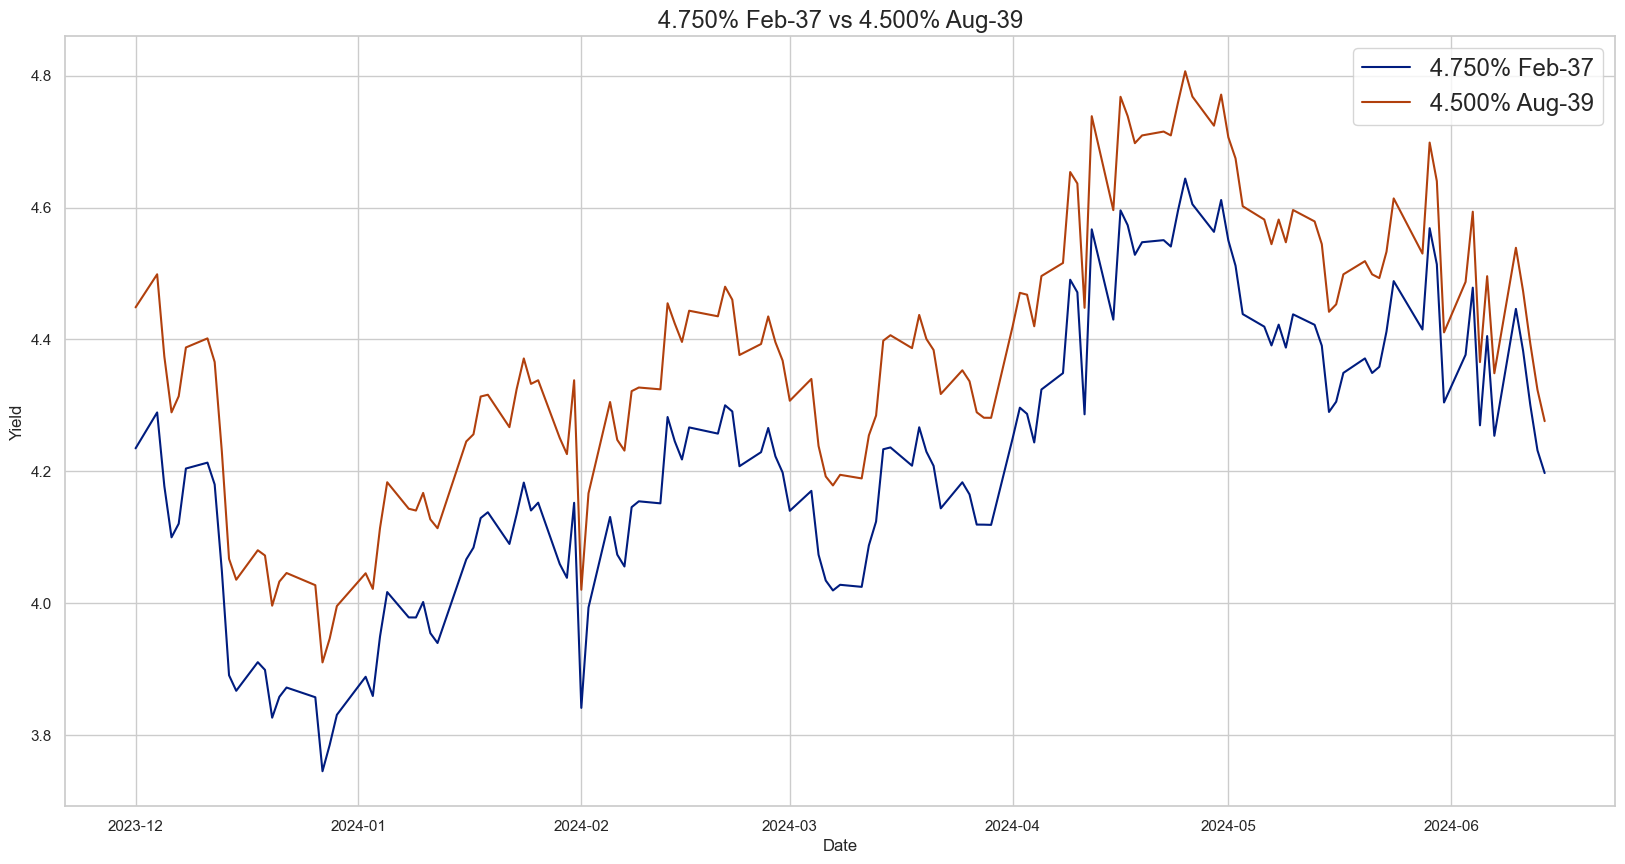

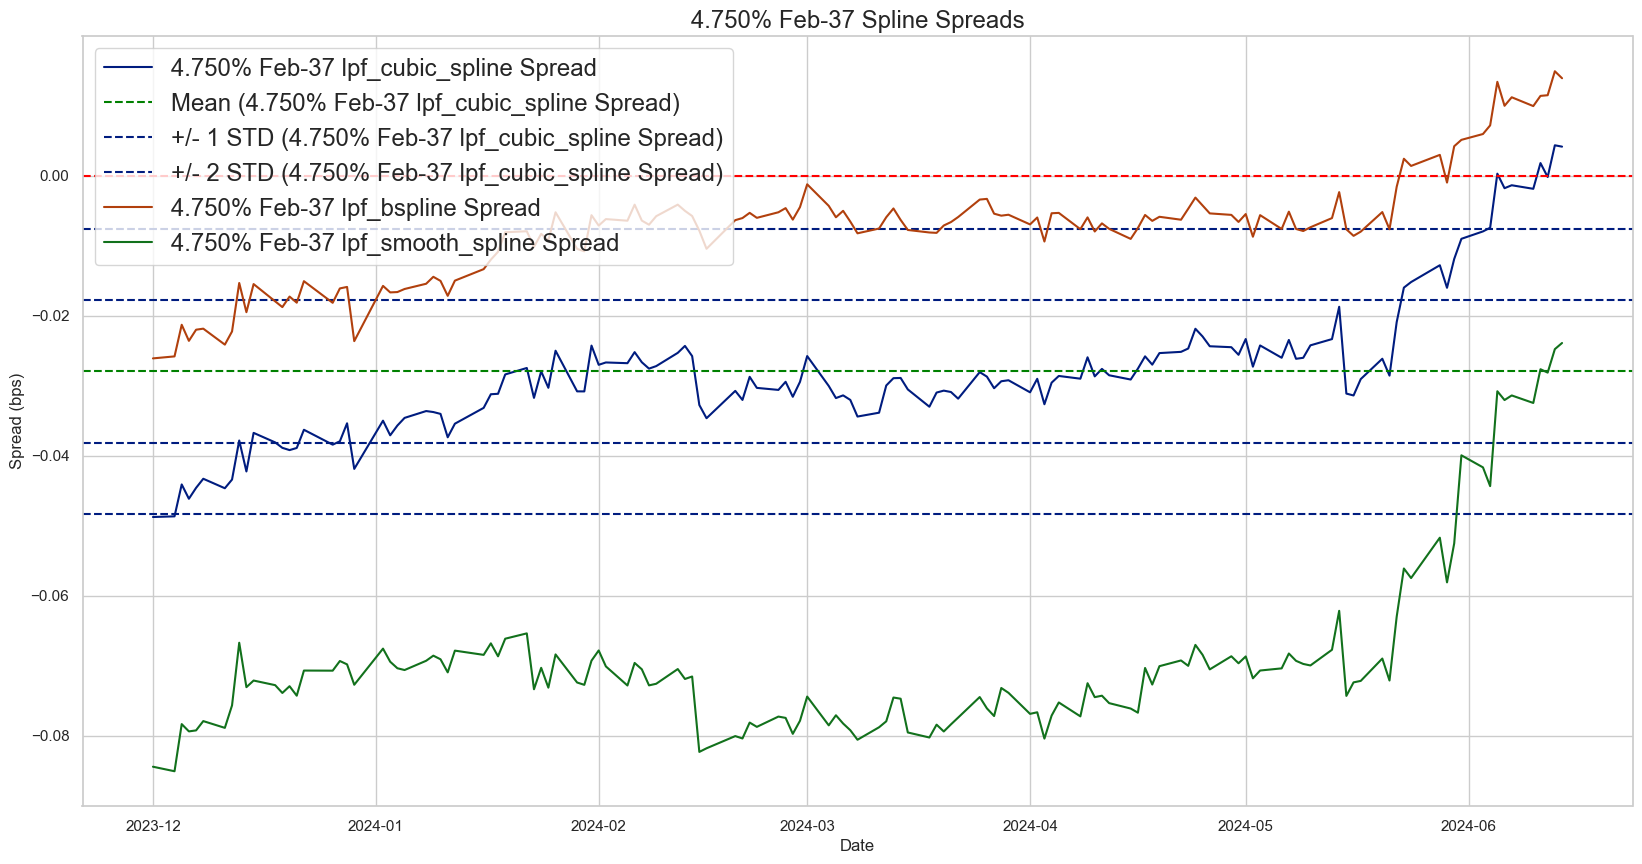

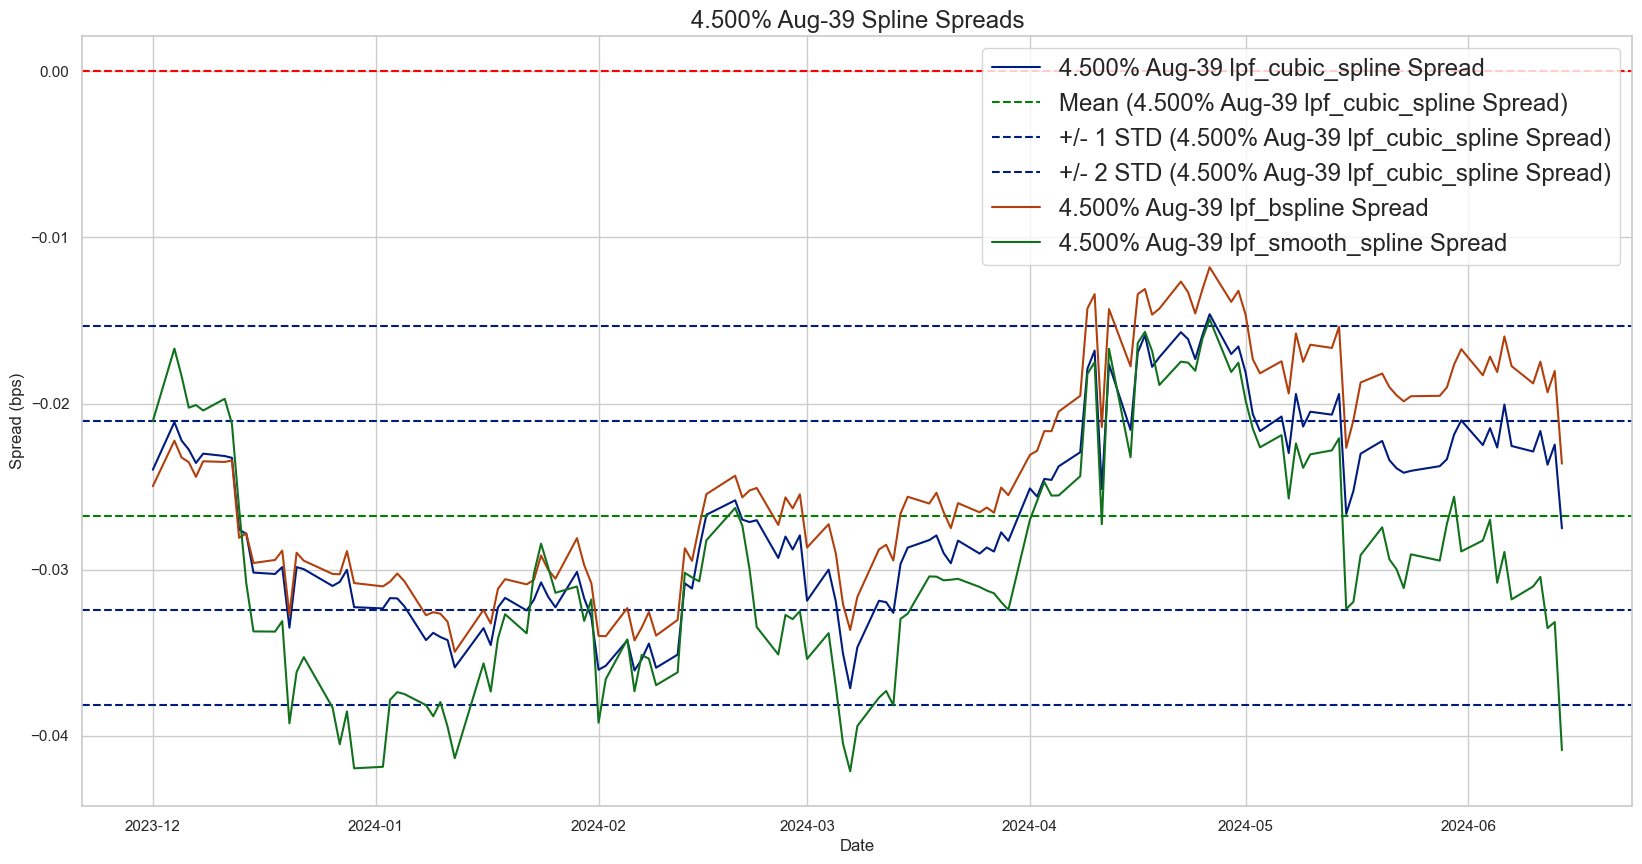

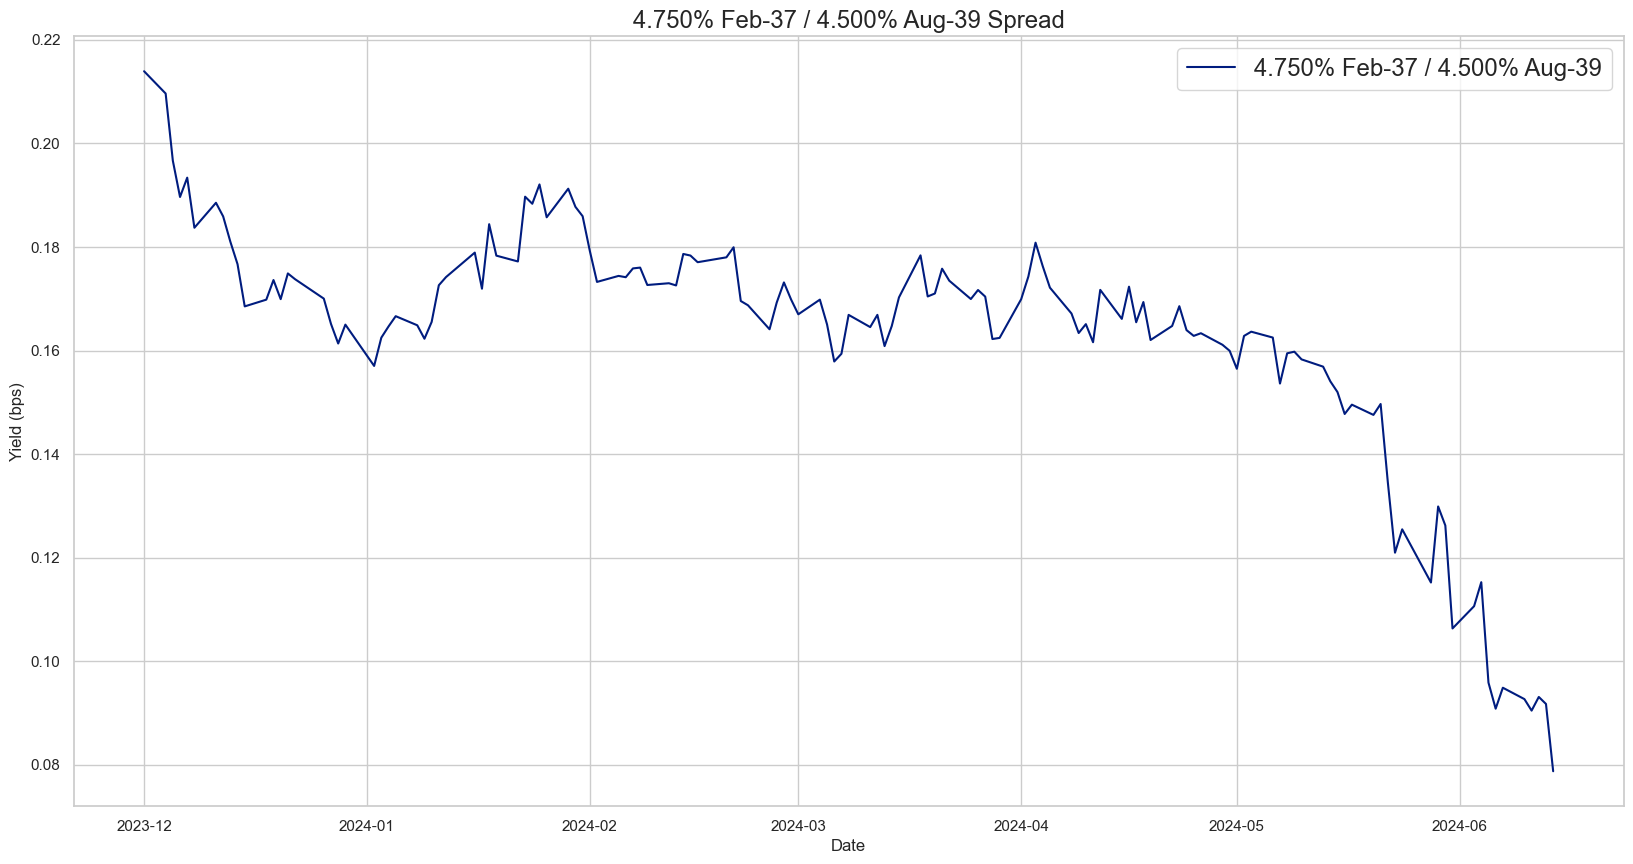

lpf_cubic_spline is Benchmark Spline


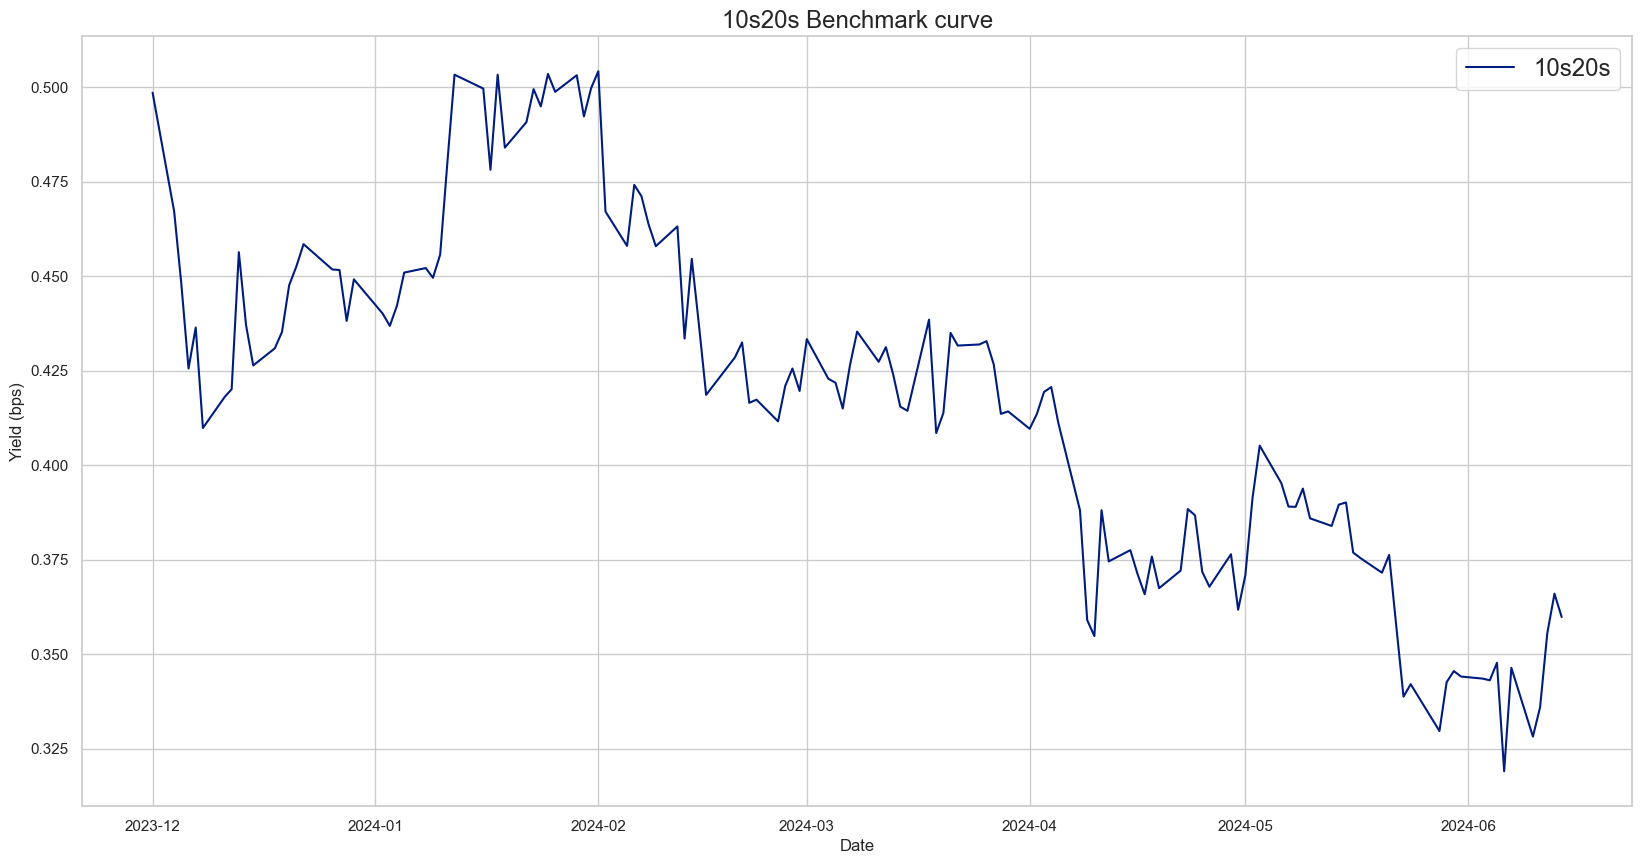

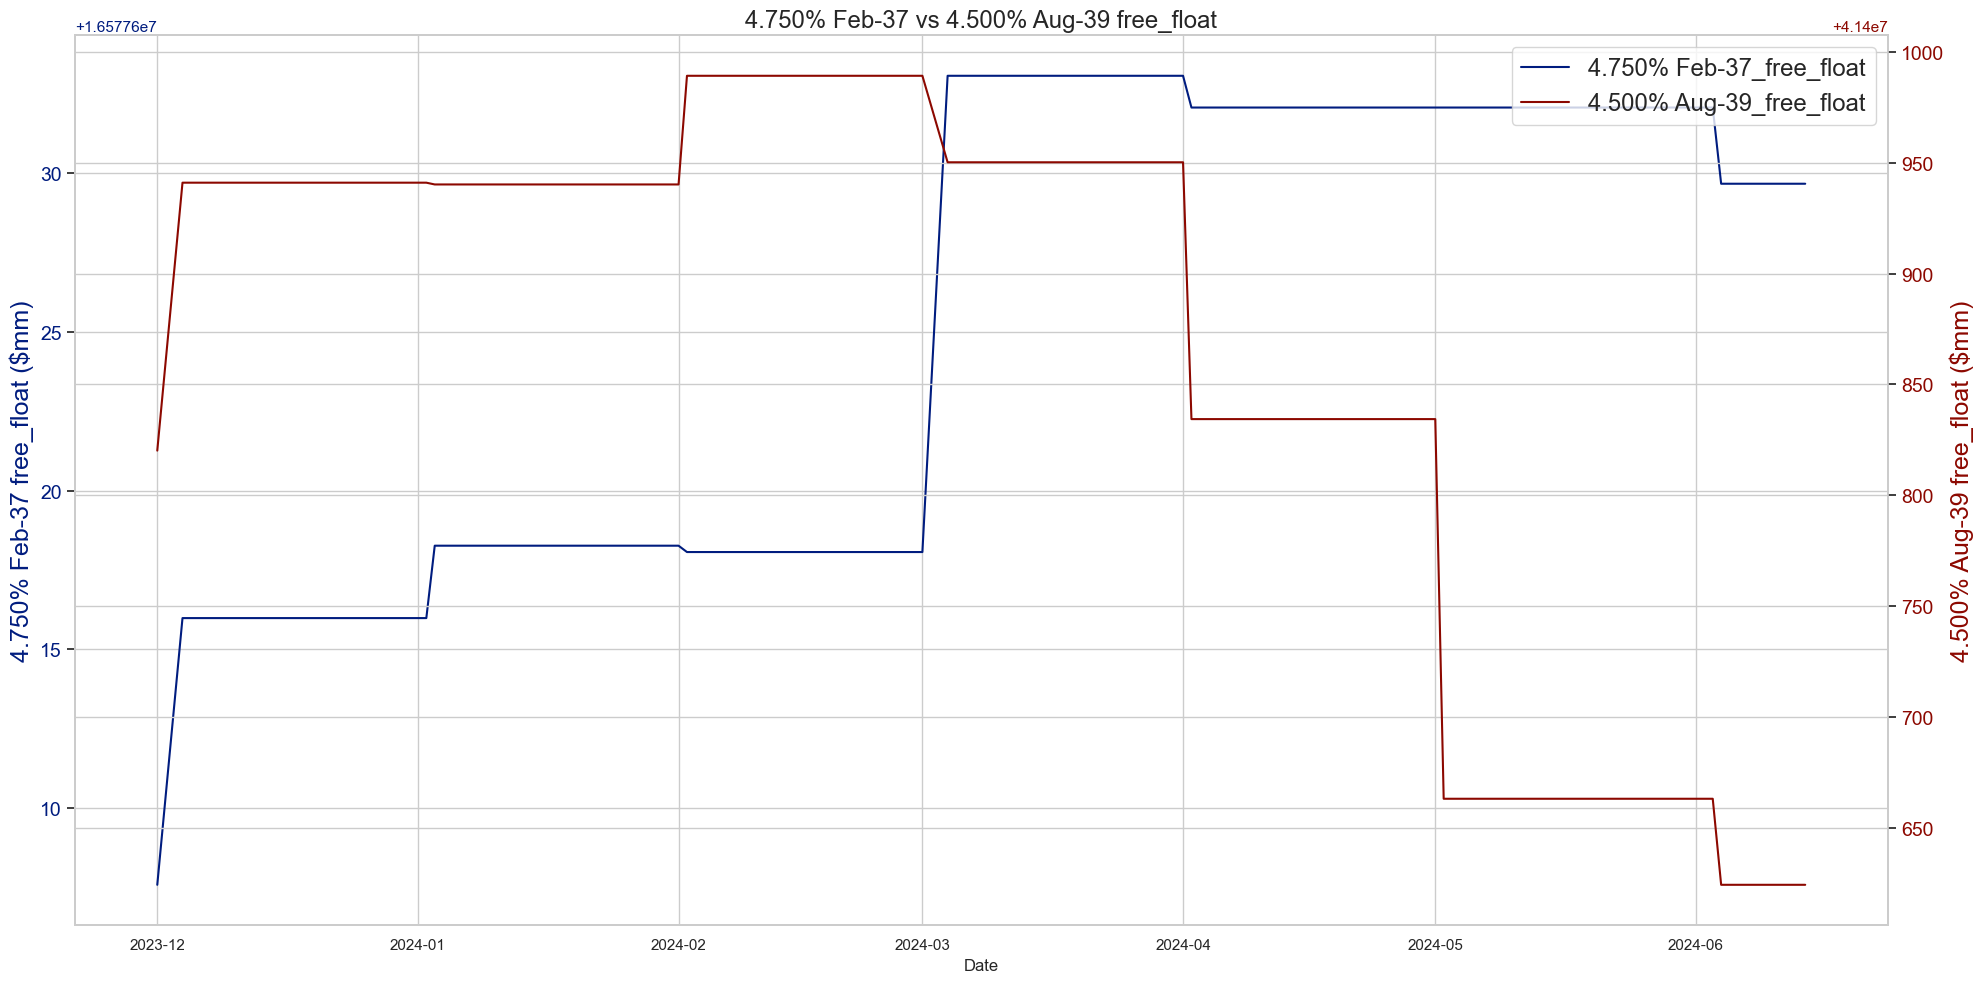

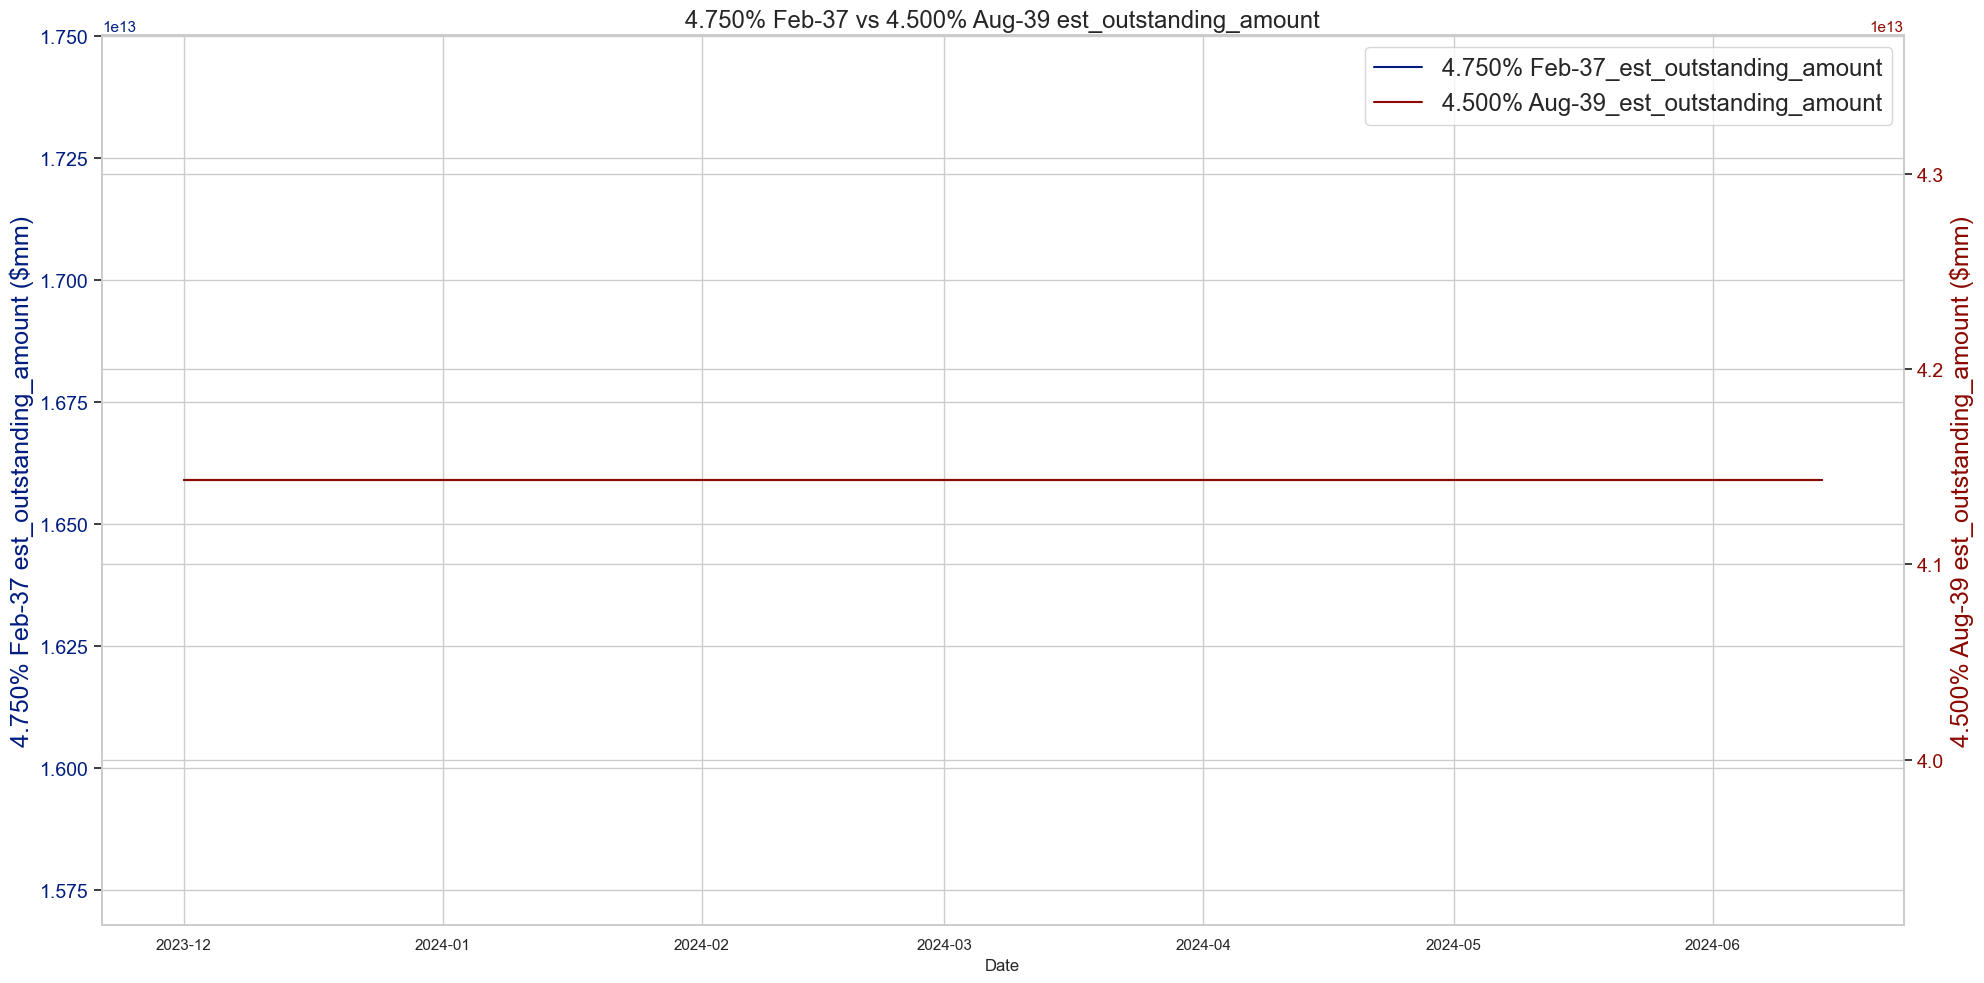

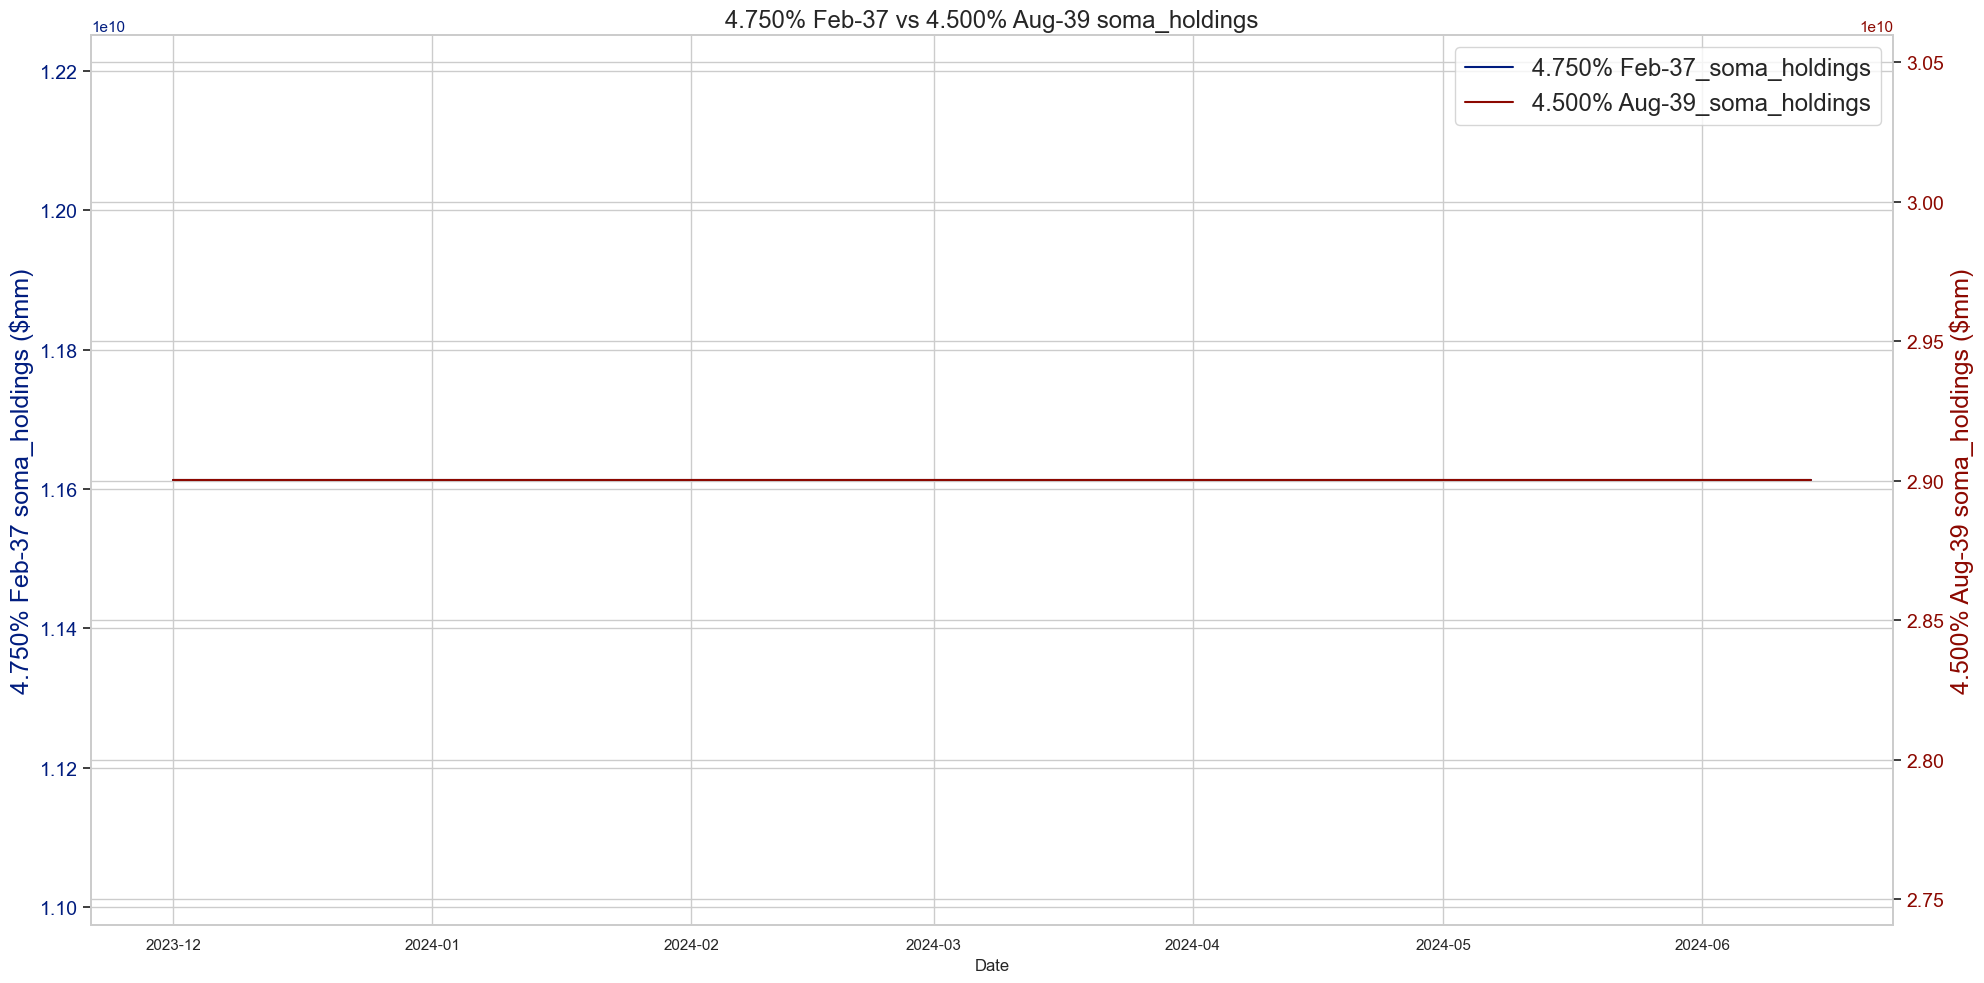

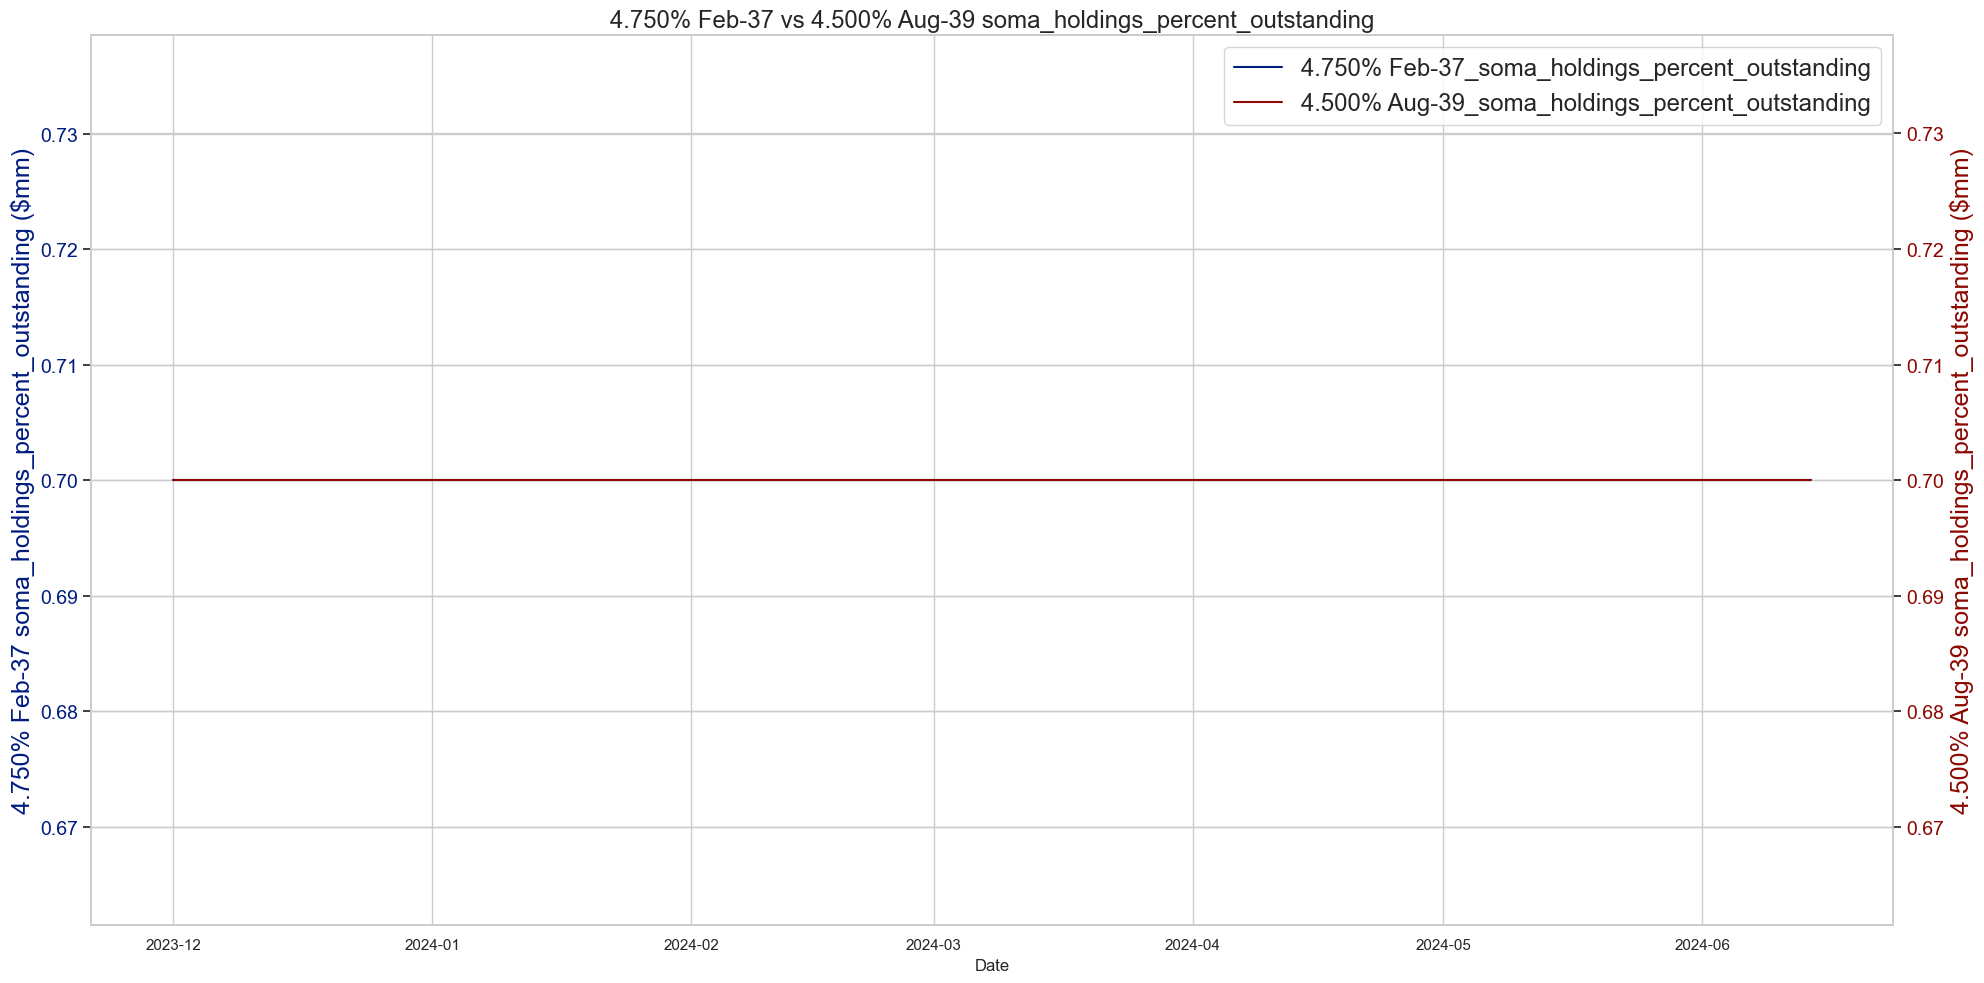

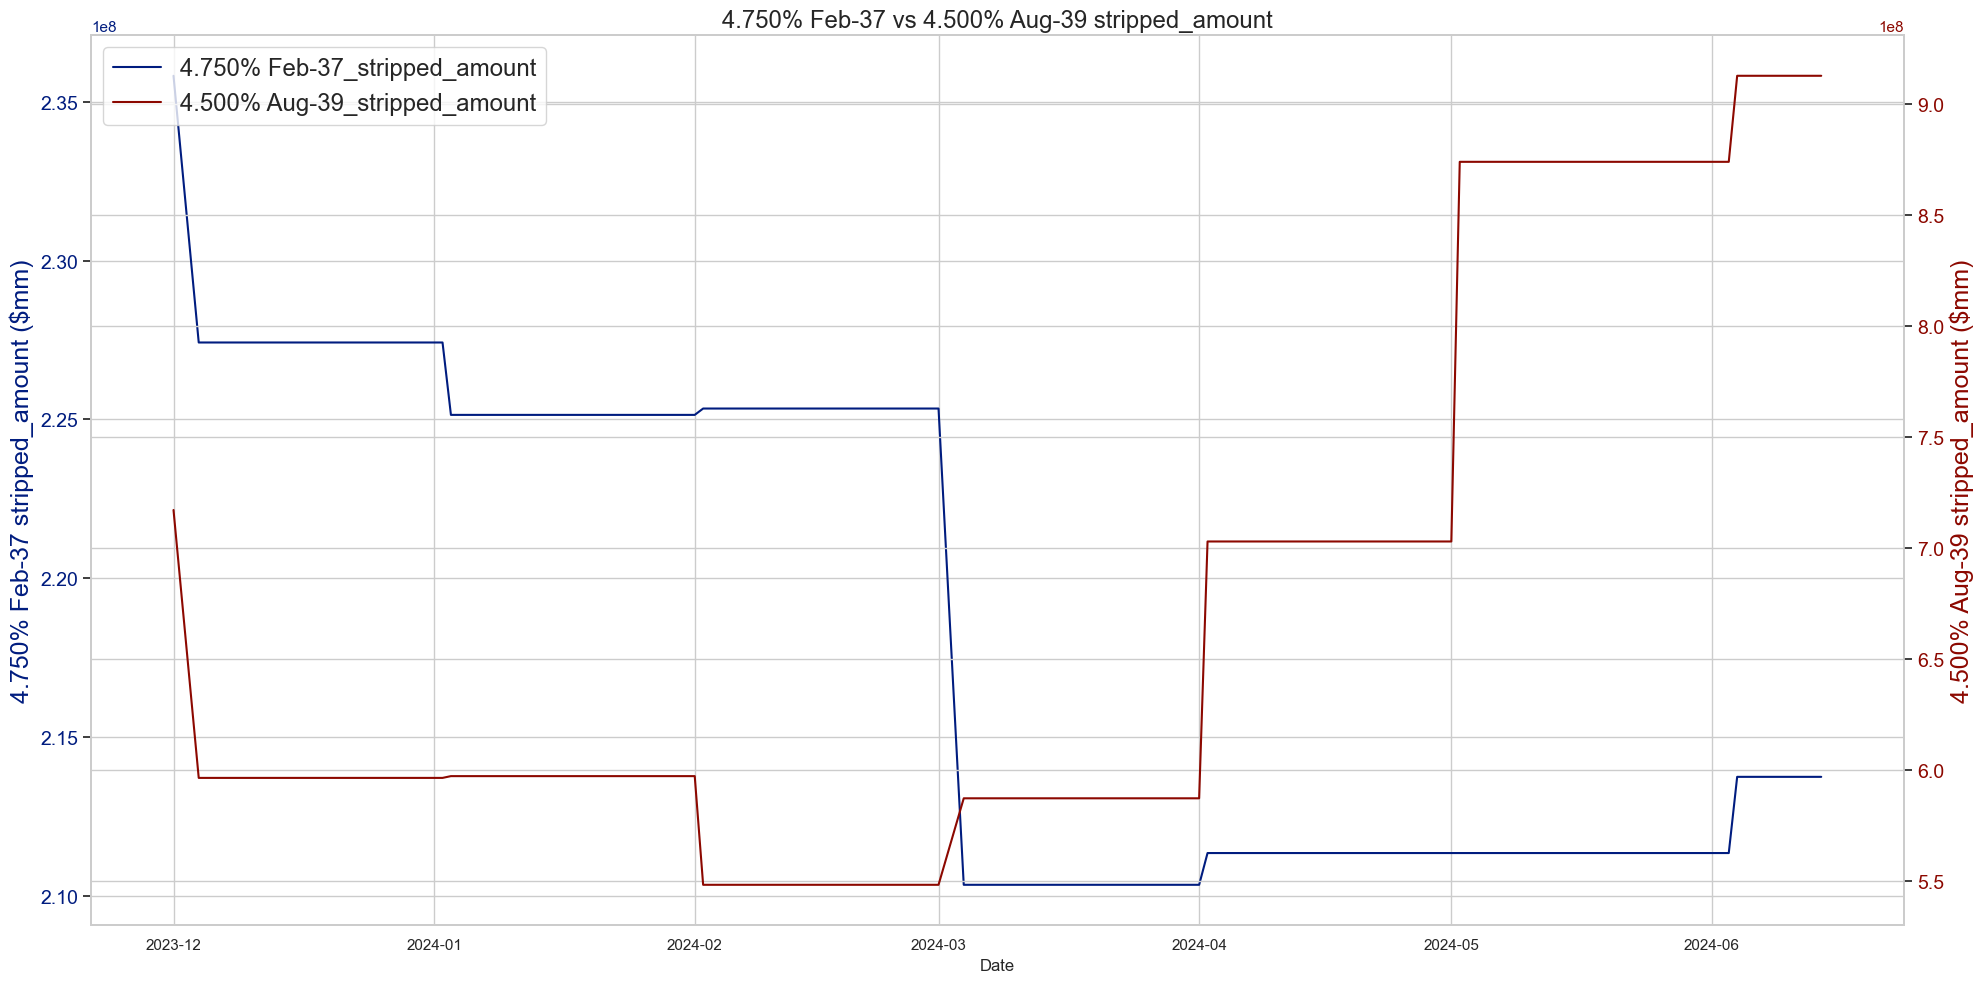

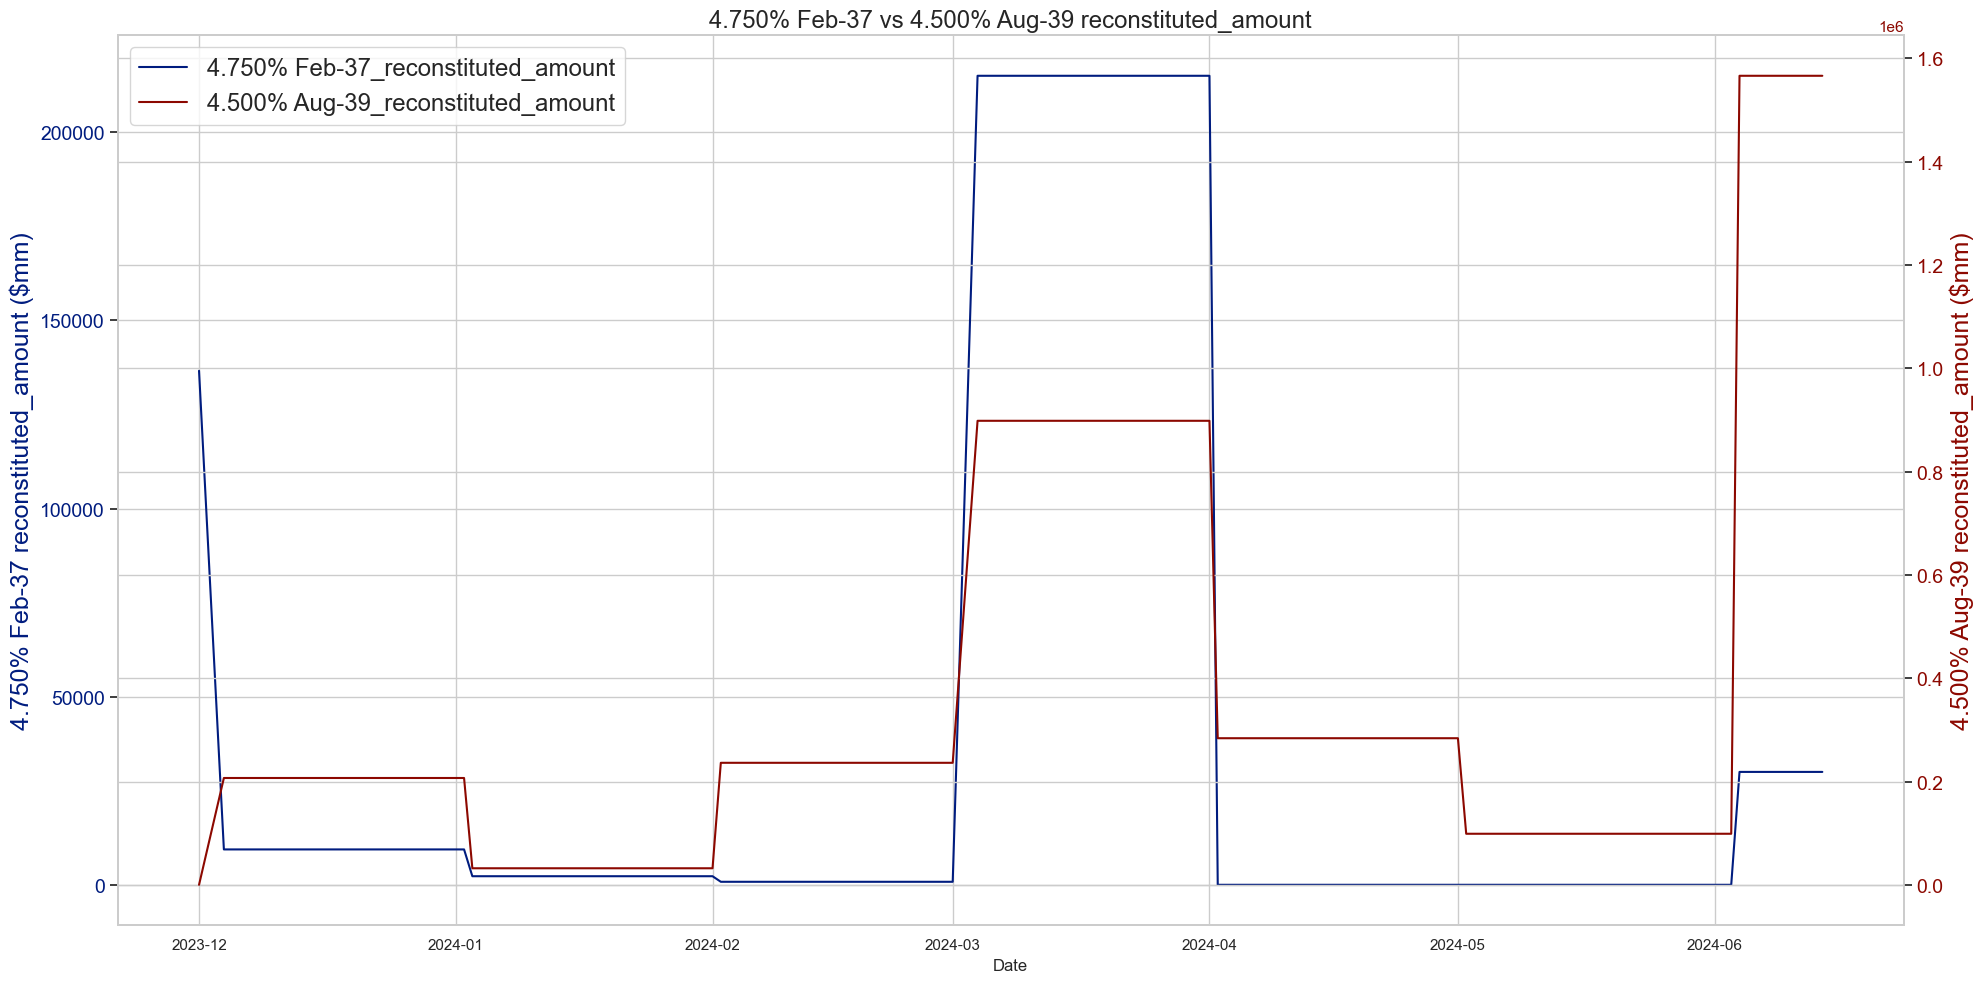

                                  OLS Regression Results                                 
Dep. Variable:     4.750% Feb-37 / 4.500% Aug-39   R-squared:                       0.558
Model:                                       OLS   Adj. R-squared:                  0.554
Method:                            Least Squares   F-statistic:                     168.8
Date:                           Sun, 06 Oct 2024   Prob (F-statistic):           1.72e-25
Time:                                   19:02:57   Log-Likelihood:                 367.53
No. Observations:                            136   AIC:                            -731.1
Df Residuals:                                134   BIC:                            -725.2
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

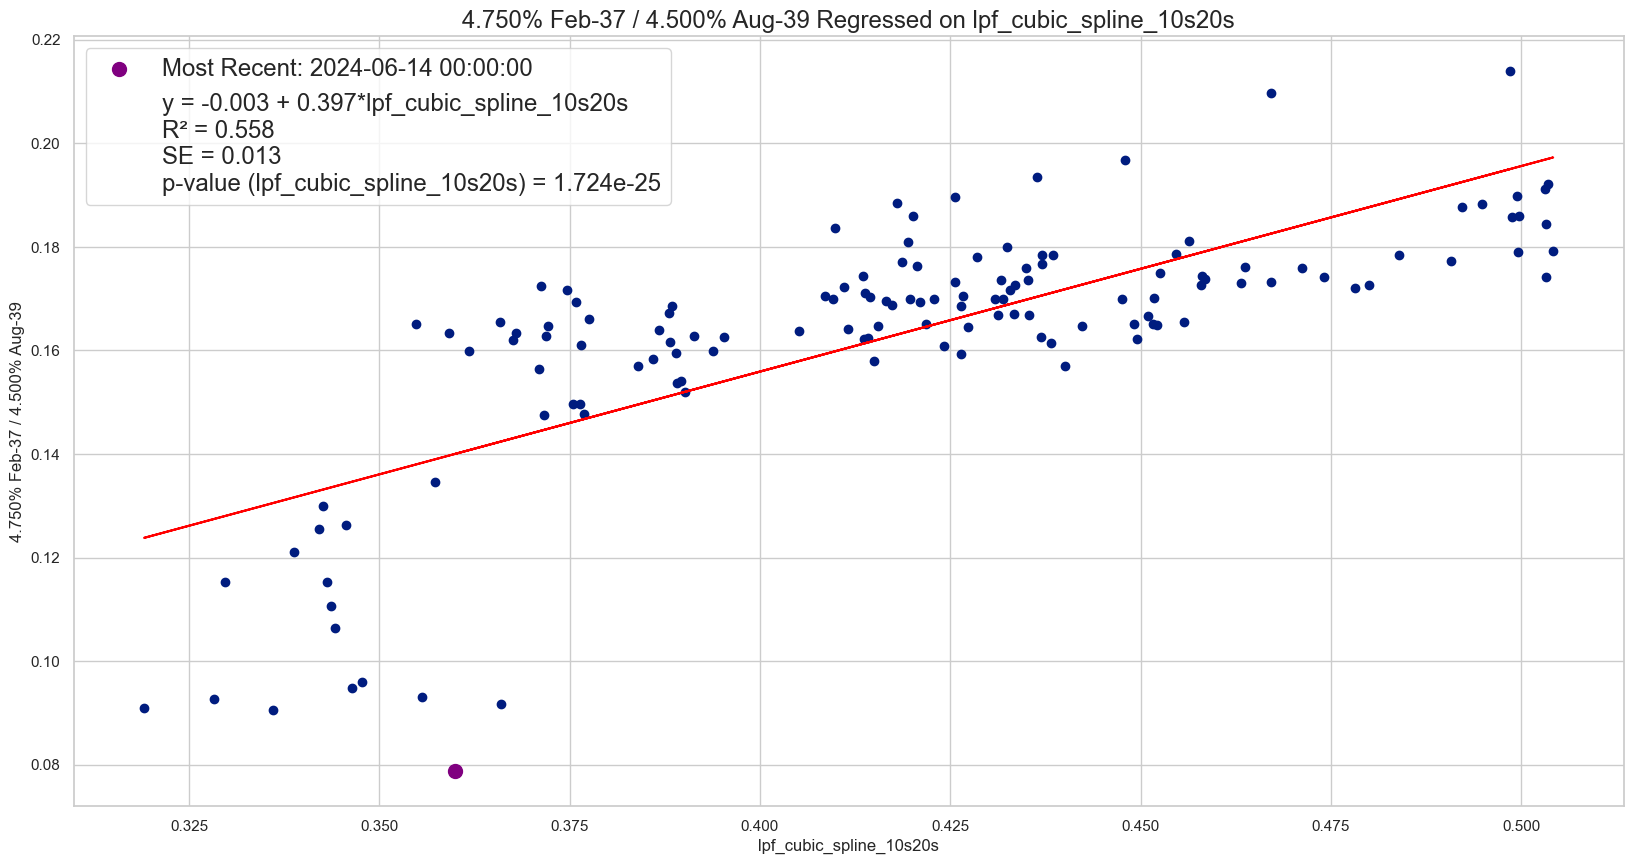

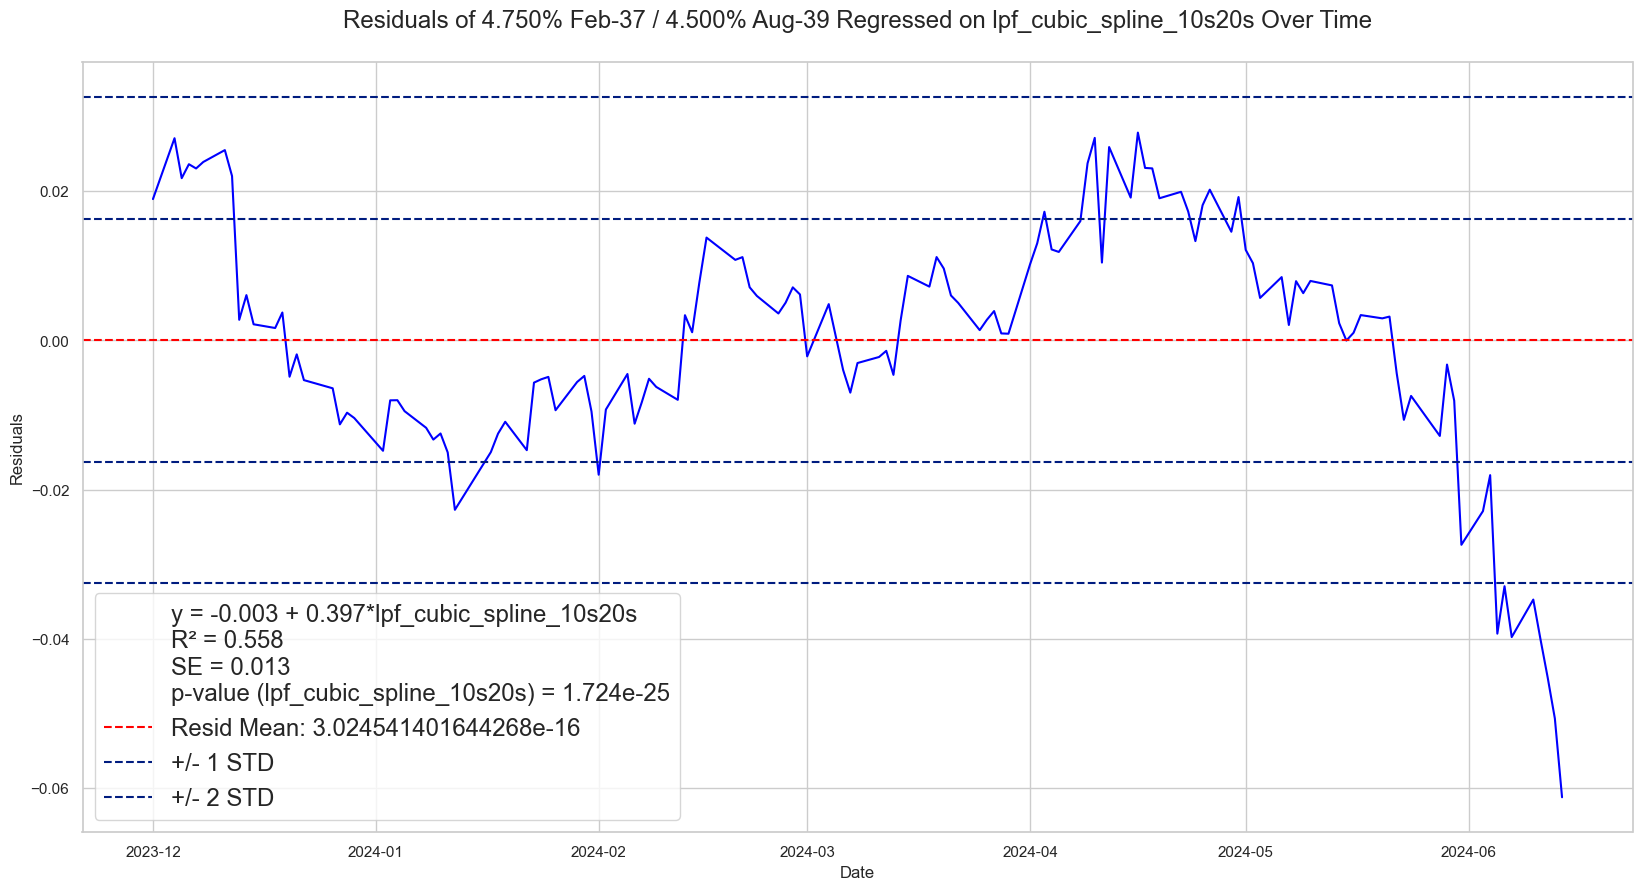

                                  OLS Regression Results                                 
Dep. Variable:     4.750% Feb-37 / 4.500% Aug-39   R-squared:                       0.348
Model:                                       OLS   Adj. R-squared:                  0.343
Method:                            Least Squares   F-statistic:                     71.47
Date:                           Sun, 06 Oct 2024   Prob (F-statistic):           4.20e-14
Time:                                   19:02:58   Log-Likelihood:                 341.15
No. Observations:                            136   AIC:                            -678.3
Df Residuals:                                134   BIC:                            -672.5
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

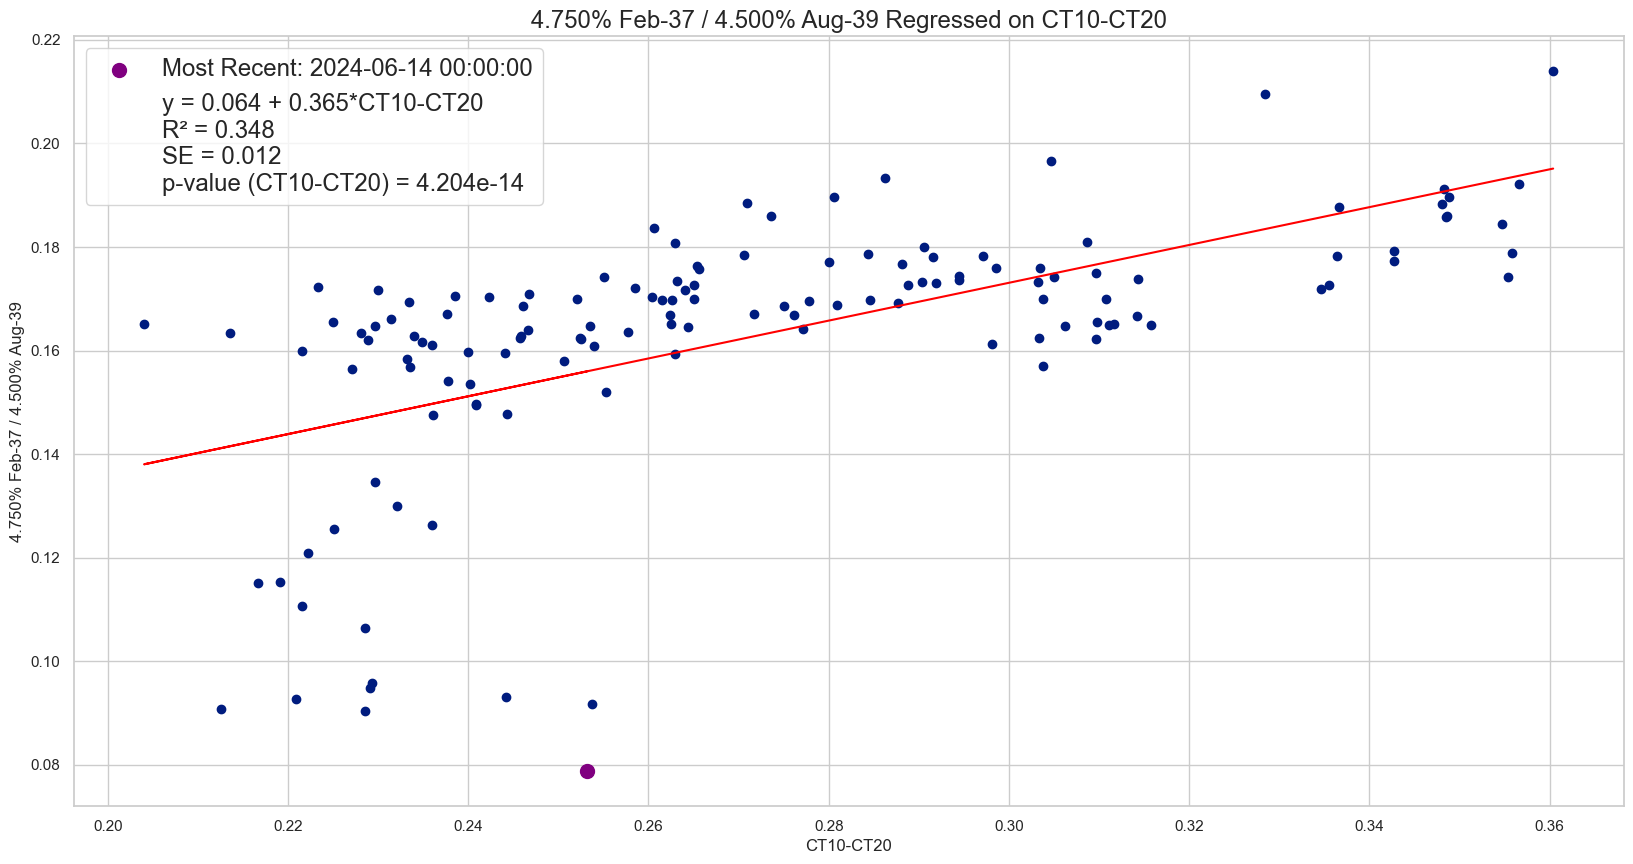

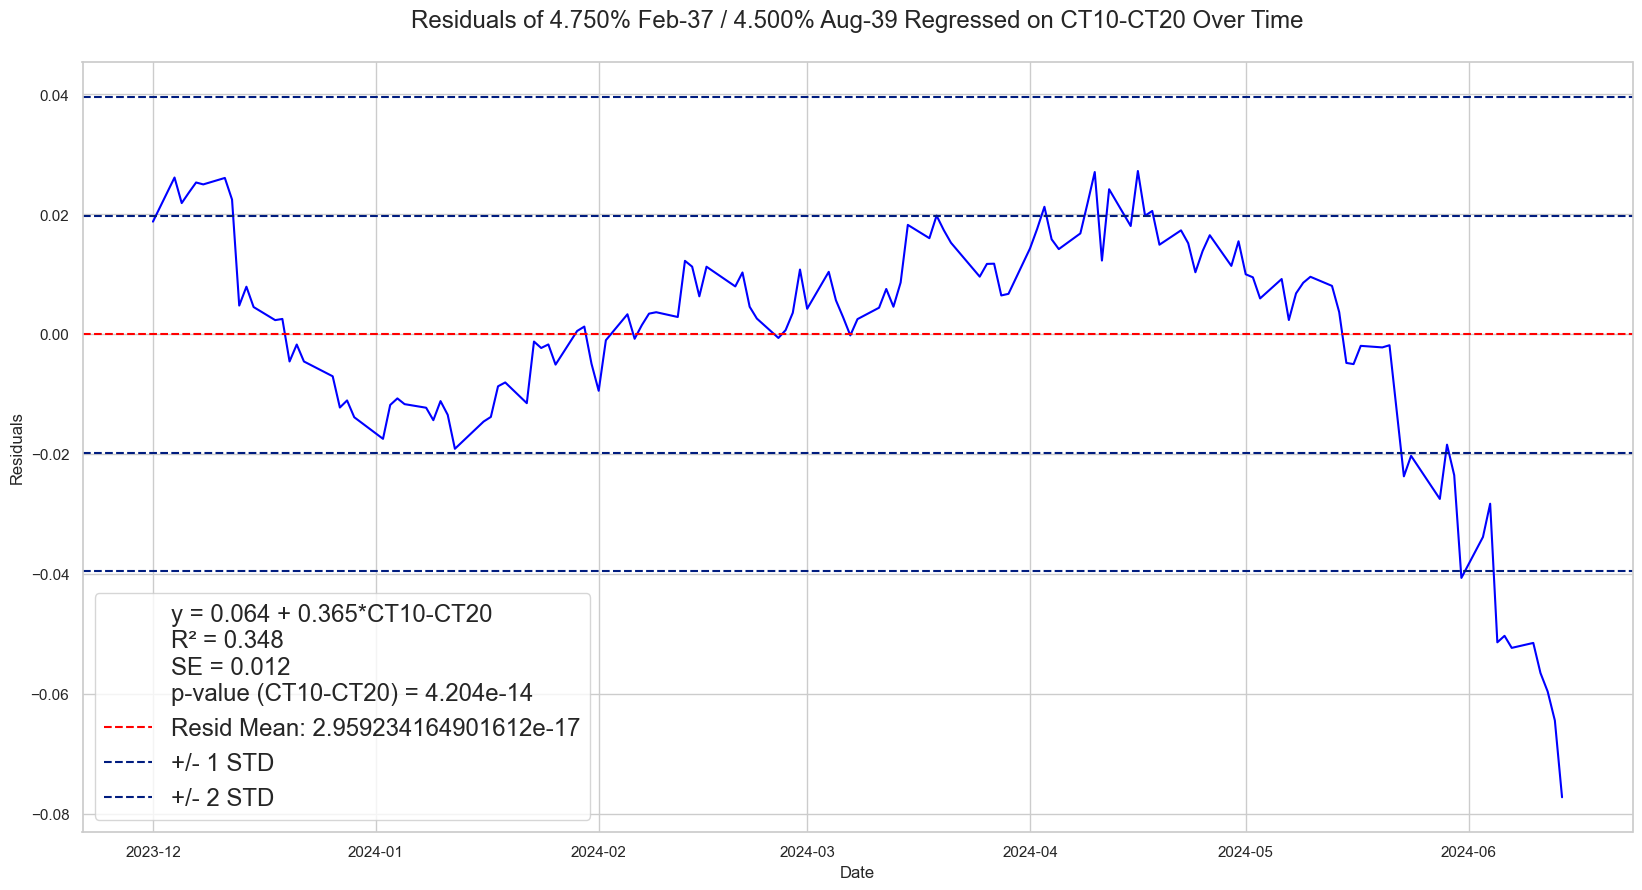

Using lpf_cubic_spline for UST Metrics Calcs


4.750% Feb-37 Metrics Calc: 136it [00:03, 36.24it/s]
4.500% Aug-39 Metrics Calc: 136it [00:03, 34.58it/s]


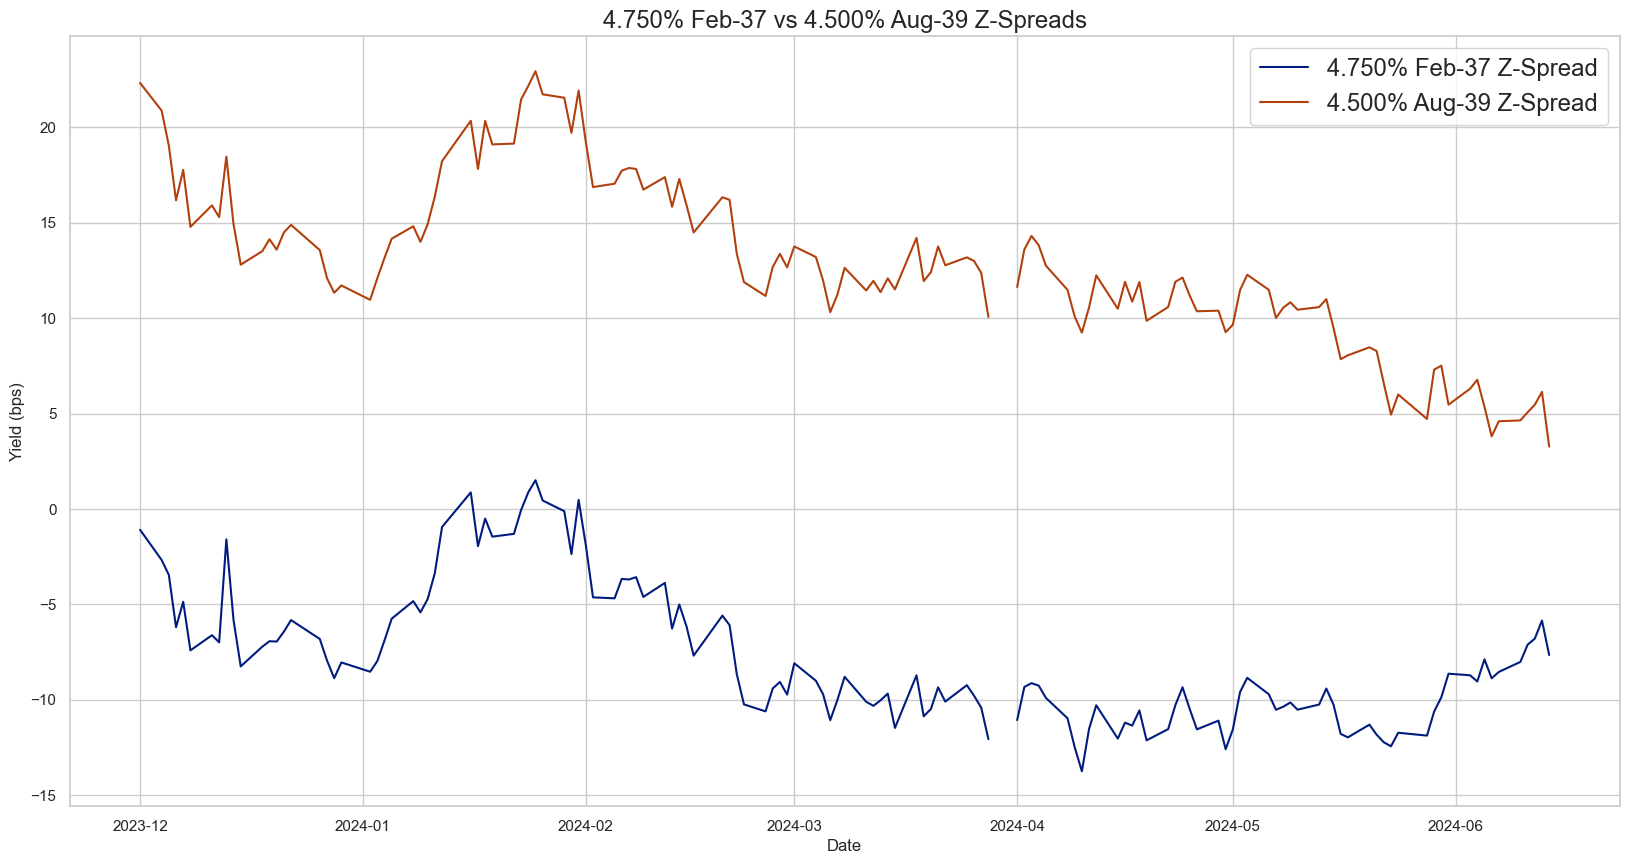

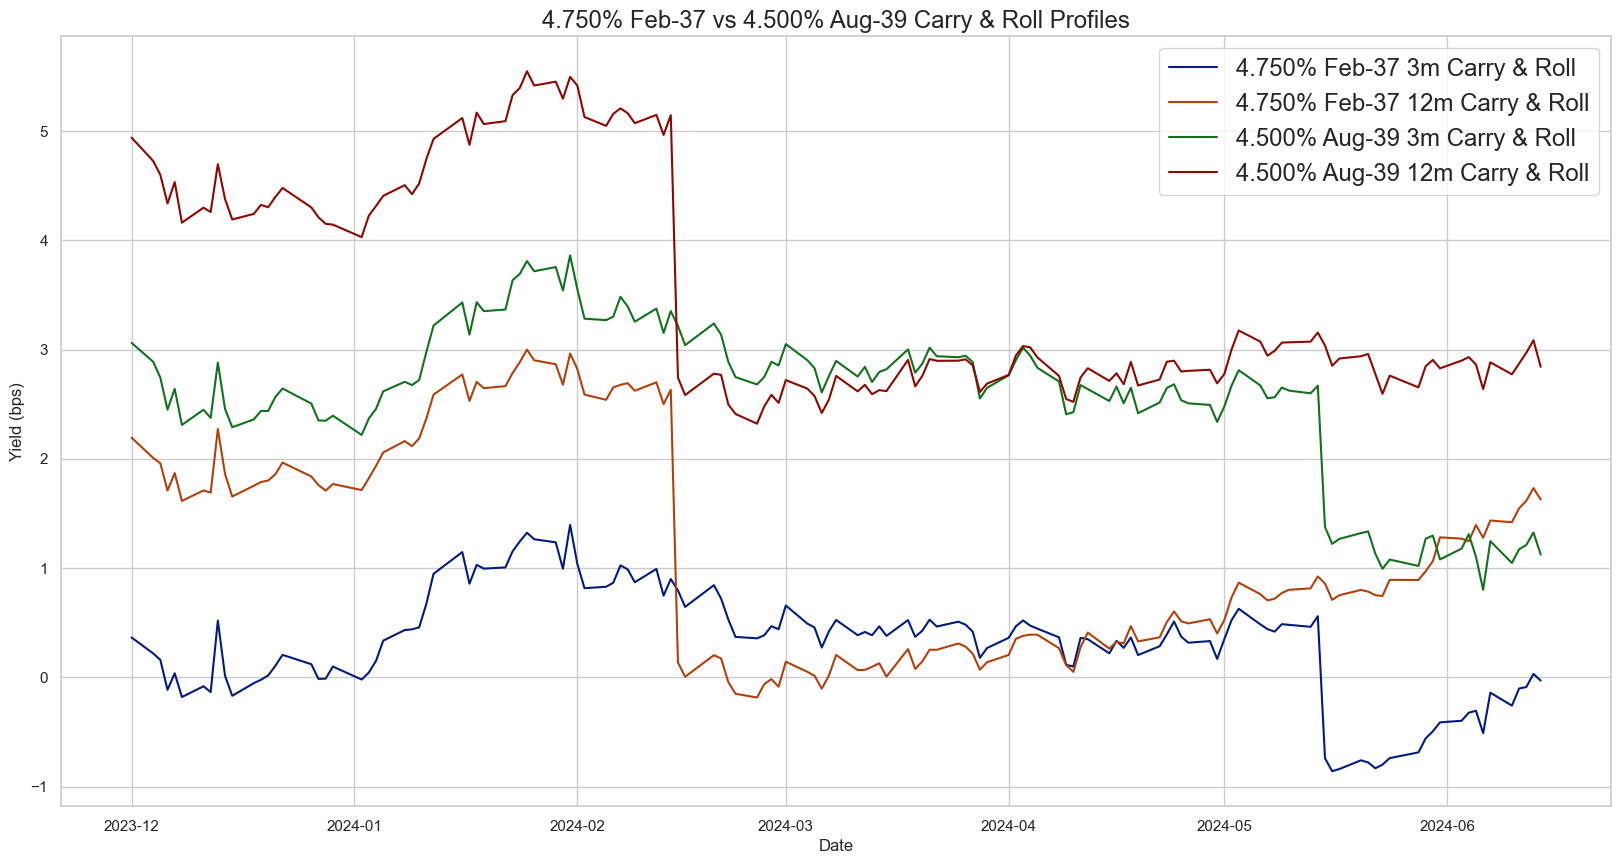

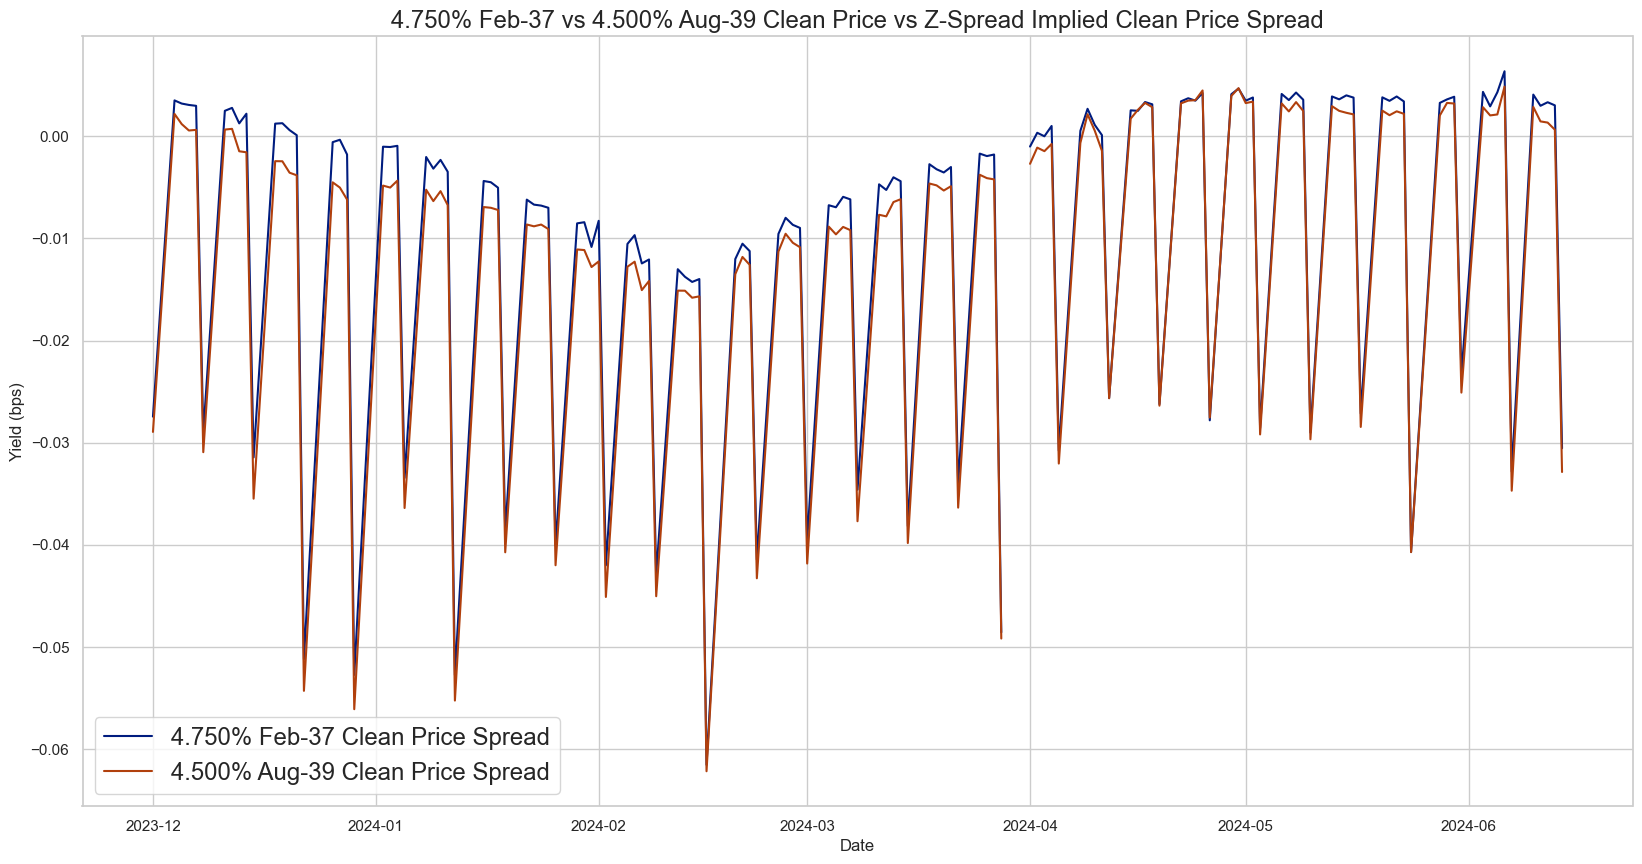

In [49]:
label1 = "4.750% Feb-37" 
label2 = "4.500% Aug-39" 

cusip_spread_rv_regression(
    curve_data_fetcher=curve_data_fetcher,
    label1=label1,
    label2=label2,
    cusip_timeseries=cusip_timeseries,
    fitted_splines_timeseries_dict={
        "lpf_cubic_spline": fitted_cubic_spline_timeseries,
        "lpf_bspline": fitted_bspline_timeseries,
        "lpf_smooth_spline": fitted_smooth_spline_timeseries,
    },
    benchmark_tenor_1=10,
    benchmark_tenor_2=20,
    ct_yields_df=ct_yields_df
)